In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pprint import pprint

import src
from src.reload import deep_reload

In [2]:
directory = 'Outputs/Random_Experiment/'

files = os.listdir(directory)

In [3]:
def adjusted_rta(values, vehicle_kw, keys = []):

    rta = src.routing.road_trip_accessibility(values)

    end_soc = src.routing.road_trip_accessibility(
        values, field = 'soc', keys = keys,
    )

    excess_chg_time = (end_soc - .1) * vehicle_kw['capacity'] / vehicle_kw['charge_rate']

    return (rta - excess_chg_time) / 3600

In [4]:
graph = src.graph.graph_from_json('Outputs/graph_empty.json')

cities = [k for k, v in graph._node.items() if v['type'] == 'city']

In [5]:
deep_reload(src)
import re

functions = {
    'capacity': lambda x: x[1]['capacity'] / 3.6e6,
    'charge_rate': lambda x: x[1]['charge_rate'] / 1e3,
    'risk_attitude': lambda x: (x[1]['risk_attitude'][0] + x[1]['risk_attitude'][1]) / 2,
    'arrival_ratio': lambda x: x[2]['arrival_param'][0],
    'reliability': lambda x: x[2]['reliability'],
    'graph_index': lambda x: x[0],
    'rta': lambda x: src.routing.road_trip_accessibility(x[4], keys = cities) / 3600,
    'rta_d': lambda x: src.routing.road_trip_accessibility(
        x[4], field = 'driving_time', keys = cities) / 3600,
    'rta_adj': lambda x: adjusted_rta(x[4], out[1], keys = cities),
}

paths = {}

outputs = {k: [] for k in functions.keys()}

idx = 0

for file in src.progress_bar.ProgressBar(files):

    idx = eval(re.findall(r'\d+', file)[0])

    if idx < 3000:

        continue

    with open(directory + file, 'rb') as f:

        out = pkl.load(f)

        paths[idx] = {'sng': out[0], 'paths': out[5]}

    for key, fun in functions.items():

        outputs[key].append(fun(out))

 [------>] (4530/4530) 100.00%, 407.79 it/s, 11.11 s elapsed, 0.00 s remaining

In [6]:
outputs_norm = outputs.copy()

keys = ['capacity', 'charge_rate', 'risk_attitude', 'reliability', 'arrival_ratio']

for key in keys:

    value = outputs[key]

    outputs_norm[key] = (np.array(value) - min(value)) / (max(value) - min(value))

df = pd.DataFrame(data = outputs_norm)

In [7]:
outputs_norm = outputs.copy()

df1 = pd.DataFrame(data = outputs_norm)

In [8]:
df

,capacity,charge_rate,risk_attitude,arrival_ratio,reliability,graph_index,rta,rta_d,rta_adj
0,0.908230,0.896972,0.723597,0.958649,0.911621,2,6.076117,5.457265,5.867307
1,0.818027,0.408939,0.168693,0.529178,0.678696,2,5.880004,5.456056,5.584503
2,0.290583,0.154437,0.078079,0.092293,0.280839,2,6.260520,5.469154,6.055792
3,0.131043,0.542713,0.817756,0.582347,0.965985,0,7.065462,5.488847,7.090686
4,0.291071,0.506494,0.700846,0.034134,0.576348,0,6.094450,5.467653,5.967286
...,...,...,...,...,...,...,...,...,...
1495,0.957979,0.630291,0.878309,0.657373,0.178693,1,6.363480,5.454144,6.128809
1496,0.086265,0.747336,0.095961,0.859242,0.313573,0,7.175974,5.522134,7.220362
1497,0.429492,0.696193,0.111712,0.082566,0.093674,2,5.851233,5.467904,5.712933
1498,0.748769,0.713714,0.792393,0.885416,0.537174,2,6.516207,5.454251,6.380061


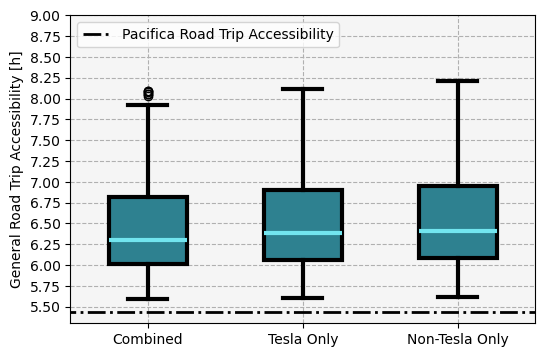

In [50]:
x = [
    df[df['graph_index'] == 0]['rta'],
    df[df['graph_index'] == 1]['rta'],
    df[df['graph_index'] == 2]['rta'],
]

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    # 'notch': True,
    'widths': .5,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#2e8190',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#72e5ef',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

_ = ax.boxplot(x, **kw)

kw = {
    'color': 'k',
    'lw': 2,
    'ls': 'dashdot',
    'label': 'Pacifica Road Trip Accessibility',
}

ax.plot([-1, 4], [5.440, 5.440], **kw)

kw = {
    'xticklabels': ['Combined', 'Tesla Only', 'Non-Tesla Only'],
    'facecolor': 'whitesmoke',
    'ylabel': 'General Road Trip Accessibility [h]',
    'yticks': np.arange(5.5, 9.25, .25),
    'xlim': (.5, 3.5),
    # 'ylim': (5.25, 9),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(loc = 2)

fig.savefig('Paper/figs/Networks_Boxplots_RTA.png', bbox_inches = 'tight', dpi = 300)

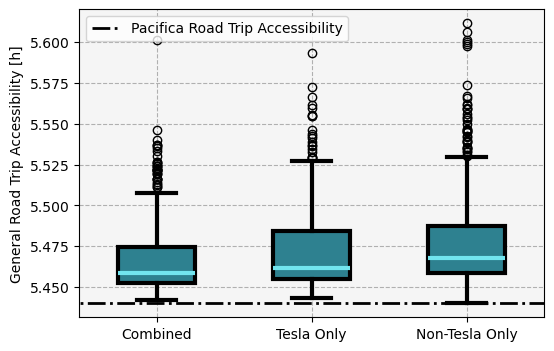

In [51]:
x = [
    df[df['graph_index'] == 0]['rta_d'],
    df[df['graph_index'] == 1]['rta_d'],
    df[df['graph_index'] == 2]['rta_d'],
]

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    # 'notch': True,
    'widths': .5,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#2e8190',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#72e5ef',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

_ = ax.boxplot(x, **kw)

kw = {
    'color': 'k',
    'lw': 2,
    'ls': 'dashdot',
    'label': 'Pacifica Road Trip Accessibility',
}

ax.plot([-1, 4], [5.440, 5.440], **kw)

kw = {
    'xticklabels': ['Combined', 'Tesla Only', 'Non-Tesla Only'],
    'facecolor': 'whitesmoke',
    'ylabel': 'General Road Trip Accessibility [h]',
    # 'yticks': np.arange(5.5, 9, .25),
    'xlim': (.5, 3.5),
    # 'ylim': (5.25, 9),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(loc = 2)

fig.savefig('Paper/figs/Networks_Boxplots_RTA_D.png', bbox_inches = 'tight', dpi = 300)

In [52]:
(6.25 - 5.5) * 60

45.0

In [32]:
# df_sel = df[(df['graph_index'] == 0)]
df_sel = df

formula = (
    'rta ~ ' +
    'C(graph_index) * ' + 
    'capacity * ' + 
    'charge_rate * ' + 
    'reliability * ' +
    'arrival_ratio * ' +
    'risk_attitude'
)

formula = (
    'rta ~ ' +
    'C(graph_index) + ' + 
    'capacity + ' + 
    'charge_rate + ' + 
    'reliability + ' +
    'arrival_ratio + ' +
    'risk_attitude'
)

model = smf.ols(formula, data = df_sel).fit()

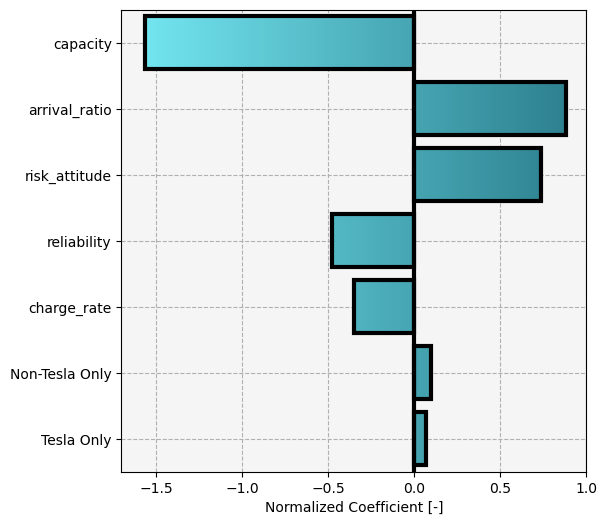

In [47]:
deep_reload(src)

label_substitutions = {
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_dict = src.analysis.significant_parameters(
    model, alpha = .05,
    label_substitutions = label_substitutions
)

out_dict.pop('Intercept')

for key, val in out_dict.items():

    val['key'] = key

out_list = np.flip(sorted(out_dict.values(), key = lambda x: np.abs(x['coefficient'])))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'ec': 'k',
    'fc': 'none',
    'lw': 3,
    'zorder': 4,
}

vmin = min([v['coefficient'] for v in out_dict.values()])
vmax = max([v['coefficient'] for v in out_dict.values()])

cmap = src.figures.colormap(["#72e5ef", "#2e8190"])
# cmap = src.figures.colormap("summer")

idx = len(out_dict) - 1

for value in out_list:

    c = value['coefficient']

    bounds = ((c - vmin) / (vmax - vmin), (0 - vmin) / (vmax - vmin))
    gradient = np.atleast_2d(np.linspace(bounds[1], bounds[0], 1000))

    bars = ax.barh(idx, width = c, **kw)
    bar = bars[0]
    
    x, y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    ax.imshow(
        gradient,
        cmap = cmap,
        extent=[x, x + w, y , y + h],
        aspect="auto",
        zorder = 3,
        vmin = 0,
        vmax = 1,
    )

    idx -= 1

kw = {
    'color': 'k',
    'lw': 3,
    'ls': '-',
    'zorder': 4,
}

ax.plot([0, 0], [-1, 7], **kw)

kw = {
    'yticks': list(range(len(out_dict))),
    'xlabel': 'Normalized Coefficient [-]',
    'yticklabels': np.flip([v['key'] for v in out_list]),
    'facecolor': 'whitesmoke',
    'ylim': (-.5, 6.5),
    'xlim': (-1.7, 1),
    # 'xticks': np.arange(-1.7, 1.1, .2),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

fig.savefig('Paper/figs/significant_parameters.png', bbox_inches = 'tight', dpi = 300)

In [34]:
deep_reload(src)

label_substitutions = {
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string = src.analysis.significant_parameters_tabular(
    model, alpha = .05,
    label_substitutions = label_substitutions
)

print(out_string)

\hline {\small Intercept } & 6.842 & 0.000 \\
\hline {\small capacity } & -1.564 & 0.000 \\
\hline {\small Tesla Only } & 0.067 & 0.000 \\
\hline {\small charge_rate } & -0.352 & 0.000 \\
\hline {\small reliability } & -0.480 & 0.000 \\
\hline {\small arrival_ratio } & 0.880 & 0.000 \\
\hline {\small risk_attitude } & 0.734 & 0.000 \\
\hline {\small Non-Tesla Only } & 0.098 & 0.000 \\



In [35]:
deep_reload(src)

label_substitutions={
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string=src.analysis.model_anova_tabular(
    model, df, 'rta', 4, c = 3,
)

print(out_string)

1452 47 1499
\hline R & R-Squared & Adjusted R-Squared & Std. Error \\
\hline 0.943 & 0.890 & 0.887 & 0.000 \\
\hline
\hline Category & Sum of Squares & DOF & Mean Squares \\
\hline Model & 469.958 & 47 & 9.999 \\
\hline Error & 58.001 & 1452 & 0.040 \\
\hline Total & 527.960 & 1499 & 0.352 \\
\hline  \multicolumn{2}{|c|}{$F$} &  \multicolumn{2}{c|}{$P(>F)$}  \\
\hline  \multicolumn{2}{|c|}{250.317} &  \multicolumn{2}{c|}{0.000}  \\
\hline
None


In [36]:
stations_used = {}

graph_index = df['graph_index'].to_numpy()

for idx, values in paths.items():

    # if values['sng'] != 0:

    #     continue

    path_collection = values['paths']

    for path_col in path_collection.values():

        for path in path_col.values():
            # print(path)

            for p in path:

                # print(p)

                if p in stations_used:

                    stations_used[p] += 1

                else:

                    stations_used[p] = 1
    #             print(p)
    #             break
    #         break
    #     break
    # break

In [37]:
len(stations_used)

328

In [38]:
graph = src.graph.graph_from_json('Outputs/sng_combined.json')
nodes = graph._node

In [39]:
nodes = graph._node

utilization = [v for k, v in stations_used.items() if 'station' in k]
ris = [nodes[k]['n_dcfc'] for k, v in stations_used.items() if 'station' in k]
ris_gen = [n['n_dcfc'] for k, n in nodes.items() if 'station' in k]
network = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]
# exp_delay = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]

In [40]:
un, unc = np.unique(network, return_counts = True)
indices = np.argsort(unc)

un = un[indices]
unc = unc[indices]

x = np.array(list(range(len(unc))))

In [41]:
networks_general = [v['network'] for k, v in nodes.items() if 'station' in k]
ung, ungc = np.unique(networks_general, return_counts = True)
indices = [np.argwhere(ung == n) for n in un]
indices = np.array([idx[0][0] for idx in indices])
# indices

ung = ung[indices]
ungc = ungc[indices]

xx = np.array(list(range(len(ungc))))

# x = list(range(len(unc)))

In [42]:
len(indices)

16

In [43]:
ung, un

(array(['BP_PULSE', 'Blink Network', 'CHARGENET', 'NOODOE', '7CHARGE',
        'CIRCLE_K', 'EVGATEWAY', 'RIVIAN_ADVENTURE', 'EVCS',
        'SHELL_RECHARGE', 'EV Connect', 'Non-Networked', 'eVgo Network',
        'ChargePoint Network', 'Electrify America', 'Tesla'], dtype='<U19'),
 array(['BP_PULSE', 'Blink Network', 'CHARGENET', 'NOODOE', '7CHARGE',
        'CIRCLE_K', 'EVGATEWAY', 'RIVIAN_ADVENTURE', 'EVCS',
        'SHELL_RECHARGE', 'EV Connect', 'Non-Networked', 'eVgo Network',
        'ChargePoint Network', 'Electrify America', 'Tesla'], dtype='<U19'))

In [44]:
len(x), len(xx)

(16, 16)

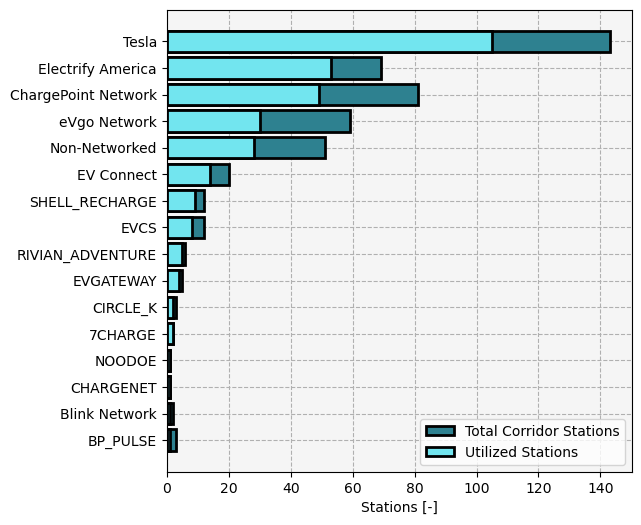

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'color': '#2e8190',
    'ec': 'k',
    'lw': 2,
    'zorder': 3,
    'label': 'Total Corridor Stations'
}

ax.barh(x, ungc, **kw)


kw = {
    'color': '#72e5ef',
    'ec': 'k',
    'lw': 2,
    'zorder': 4,
    'label': 'Utilized Stations'
}

ax.barh(x, unc, **kw)

kw = {
    'xlabel': 'Stations [-]',
    'yticks': x,
    'yticklabels': un,
    'facecolor': 'whitesmoke',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 3,
}

_ = ax.grid(**kw)

_ = ax.legend()

fig.savefig('Paper/figs/corridor_station_utilization.png', bbox_inches = 'tight', dpi = 300)

In [188]:
from scipy.stats import rv_histogram

x = list(range(1, 71))

h_u = rv_histogram(np.histogram(ris, bins = x))
h_g = rv_histogram(np.histogram(ris_gen, bins = x))

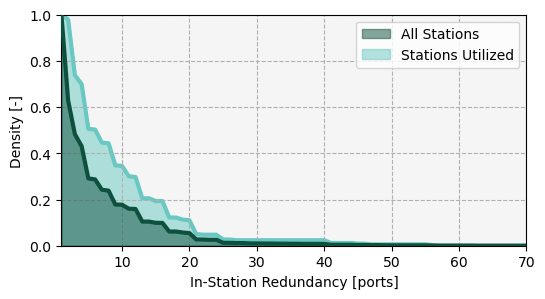

In [189]:
fig, ax = plt.subplots(1, 1, figsize = (6, 3))

kw = {
    'color': '#0e503e',
    'zorder': 3,
    'lw': 3,
}

ax.plot(x, h_g.sf(x), **kw)

kw = {
    'color': '#0e503e',
    'zorder': 2,
    'alpha': .5,
    'label': 'All Stations',
}

ax.fill_between(x, 0, h_g.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 1,
    'lw': 3,
}

ax.plot(x, h_u.sf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 0,
    'alpha': .5,
    'label': 'Stations Utilized'
}

ax.fill_between(x, 0, h_u.sf(x), **kw)

kw = {
    'xlim': [x[0], x[-1]],
    'ylim': [0, 1],
    'xlabel': 'In-Station Redundancy [ports]',
    'ylabel': 'Density [-]',
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

ax.legend()

# fig.savefig('Paper/figs/California_RIS_Hist.png', bbox_inches = 'tight', dpi = 300)